---
---

# 제 1차 해커톤 : Datathon
## 아파트 실거래가 예측

---

## " 실거래가 예측을 통해 저평가된 매물을 찾을 수 있을까? "

---

이번 프로젝트는 데이콘*DACON*에서 진행된 **아파트 실거래가 예측** 대회를 따라 진행되었습니다.

## 1. 배경  
* 통계청 2015년 자료에 의하면 (https://bit.ly/2SFyzMA) 일반적인 한국인의 절반은 48.1%는 아파트에 살고 있습니다.  
  그들은 아파트 주거 선호도가 매우 높습니다. 또한 부의 증식 수단으로 생각 하기 때문에 아파트 가격에 관심이 많습니다.
<br></br>
* 이번 대회의 데이터 제공자는 직방입니다. 직방은 부동산 정보의 비대칭성과 불투명성을 해소하기 위해 노력하며,  
  중개사와 구매자를 연결하여 부동산정보 서비스 시장의 신뢰도를 높이는데 기여합니다.
<br></br>
* 최근 매물 가격 정보는 직방, 다음부동산, 네이버부동산에서 볼 수 있습니다.  
  하지만 최근 매물 가격은 아직 거래되지 않아 정확하지 않은 정보일 수 있습니다.
<br></br>
* 이에따라, 본 대회는 실 거래가와 아파트, 학교, 지하철역 정보를 제공하며,  
  아파트 구매자들의 비대칭성 정보를 해결하기 위해 미래의 실 거래가 예측을 목표로 합니다.

## 2. 목표  
* 제공된 서울/부산 지역 아파트 실 거래가 DATA를 바탕으로, **예측하는 모델**을 개발하고 **rmse를 최소화**하는게 목표입니다.

## 3. DATA  
* train.csv : 서울/부산 지역의 1,100,000여개 거래 데이터, 아파트 거래일, 지역, 전용면적, 실 거래가 등의 정보
<br></br>
* test.csv : 실 거래가를 제외하고 train.csv와 동일

---
---


# 0. This project is

# 1. Data check

#### 시작하기에 앞서 앞으로 사용하게 될 모듈과 메서드들을 호출합니다.

In [ ]:
import os
from os.path import join

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm #진행률바
import re
import optuna
from optuna.integration import XGBoostPruningCallback

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import bisect

from sklearn.preprocessing import  LabelEncoder #문자를 숫자로 인코딩
from sklearn.model_selection import TimeSeriesSplit #변수n을 입력, n번의 반복으로 교차검즘을 할 것인지 정하는 것

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge #선형 모델
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor            ## XGBoost GPU 가속(https://bo-10000.tistory.com/124)
from sklearn.ensemble import VotingRegressor        ## 앙상블, 투표 기법


from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [ ]:
# 코랩
# from google.colab import drive
# drive.mount('/content/drive')
# data_dir = '/content/drive/MyDrive/AIFFEL/Workspace/Project/Datathon/data'

# 로컬
data_dir = os.getenv('USERPROFILE') + '/Datathon/data'

In [ ]:
## 데이터 로컬 환경에 맞게 변경
# data_dir = "./data"

In [ ]:
train_path = join(data_dir, 'train.csv')
test_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_path, index_col=0).reset_index(drop=True)
test_X = pd.read_csv(test_path, index_col=0).reset_index(drop=True)

print(train.shape, test_X.shape)

(1216553, 13) (5463, 12)


---

#### 프로젝트 진행 중 메모리 이슈로 인해 train DATA의 수를 조절했습니다.

In [ ]:
train_copy = train.copy()

## 표본 추출을 통해 train 데이터의 수를 줄이겠습니다.
# seed for random number generator for reproducibility
train = train.sample(n=123456, random_state=999)
train.shape

(123456, 13)

---

### Train / Test dataset을 살펴보자

In [ ]:
train.head()

,apartment_id,city,gu,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
107102,9203,서울특별시,성북구,돈암동,636,이수브라운스톤돈암,돈암동 636 이수브라운스톤돈암,59.99,2004,201002,1~10,18,33500
383032,11351,서울특별시,구로구,개봉동,476,한마을,개봉동 476 한마을,59.57,1999,201008,21~31,16,28300
468735,7238,서울특별시,관악구,신대방동,712,신대방경남,신대방동 712 신대방경남,112.05,2003,201606,21~30,15,58500
618109,5763,서울특별시,강남구,길동,53,삼익파크맨션,길동 53 삼익파크맨션,62.91,1983,200904,11~20,10,30000
842730,2402,부산광역시,북구,화명동,2306,대림쌍용강변타운,화명동 2306 대림쌍용강변타운,131.07,2004,201607,1~10,7,40500


In [ ]:
test_X.head()

,apartment_id,city,gu,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor
0,10453,서울특별시,강서구,목동,938,청학,목동 938 청학,35.5500,2002,201711,11~20,2
1,989,부산광역시,동구,초량동,1143-8,고관맨션,초량동 1143-8 고관맨션,68.7200,1977,201708,21~31,2
2,8597,부산광역시,사하구,괴정동,447-13,우림그린,괴정동 447-13 우림그린,72.5400,1989,201710,11~20,2
3,11086,서울특별시,강남구,대치동,1007-2,풍림아이원4차(1007-2),대치동 1007-2 풍림아이원4차(1007-2),111.5400,2004,201707,1~10,10
4,2121,부산광역시,사하구,다대동,1670,다대롯데캐슬블루,다대동 1670 다대롯데캐슬블루,119.6398,2014,201712,11~20,21


#### Columns of DATA

0. apartment_id : 아파트 아이디
1. city : 도시
2. dong : 동
3. jibun : 지번
4. apt: 아파트단지 이름
5. addr_kr : 주소
6. exclusive_use_area : 전용면적
7. year_of_completion : 설립일자
8. transaction_year_month : 거래년월
9. transaction_date : 거래날짜
10. floor : 층
11. transaction_real_price : 실거래가 (train)

---

전처리 전, 히트맵 그래프를 통해 비교 가능한 각각의 컬럼들에 대해 상관관계를 살펴보려 합니다.

<AxesSubplot:>

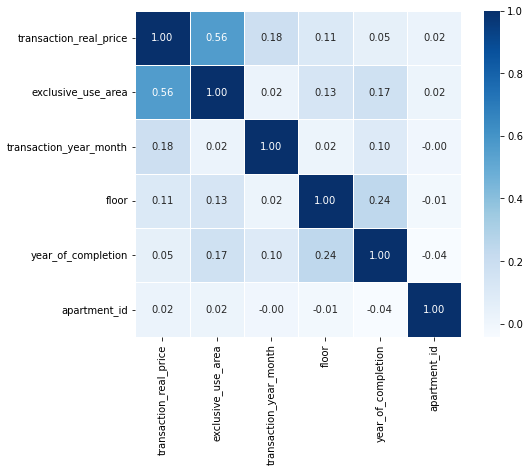

In [ ]:
#상관관계 확인
k = train.shape[1] #히트맵 변수 갯수
corr_mat = train.corr() #변수간의 상관관계
cols = corr_mat.nlargest(k, 'transaction_real_price')['transaction_real_price'].index #price기준으로 제일 큰순서대로 20개를 뽑아냄
cm = np.corrcoef(train[cols].values.T)

f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(data = cm, annot=True, square=True, fmt = '.2f', linewidths=.5, cmap='Blues', 
            yticklabels = cols.values, xticklabels = cols.values)

당연하게도 전용면적(exclusive_use_area)이 집 가격과 가장 밀접한 관계가 있어 보입니다!

---

# 2. Merge : Train data, Test data

데이터를 살펴보고 정제하기에 앞서 train / test dataset을 병합하도록 하겠습니다.

In [ ]:
## 실거래가 (일종의 정답) 을 train_y 로
train_y = train['transaction_real_price']
print(train_y.head())

print(train.shape)
## 실거래가 제외한 train 테이블을 train_X 로
train_X = train.drop('transaction_real_price', axis=1)
print(train_X.shape)

107102    33500
383032    28300
468735    58500
618109    30000
842730    40500
Name: transaction_real_price, dtype: int64
(123456, 13)
(123456, 12)


In [ ]:
## whole_X：train／test 셋 통합
whole_X = pd.concat((train_X, test_X), axis=0)
whole_X.shape

(128919, 12)

In [ ]:
whole_X.head()

,apartment_id,city,gu,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor
107102,9203,서울특별시,성북구,돈암동,636,이수브라운스톤돈암,돈암동 636 이수브라운스톤돈암,59.99,2004,201002,1~10,18
383032,11351,서울특별시,구로구,개봉동,476,한마을,개봉동 476 한마을,59.57,1999,201008,21~31,16
468735,7238,서울특별시,관악구,신대방동,712,신대방경남,신대방동 712 신대방경남,112.05,2003,201606,21~30,15
618109,5763,서울특별시,강남구,길동,53,삼익파크맨션,길동 53 삼익파크맨션,62.91,1983,200904,11~20,10
842730,2402,부산광역시,북구,화명동,2306,대림쌍용강변타운,화명동 2306 대림쌍용강변타운,131.07,2004,201607,1~10,7


In [ ]:
whole_X.describe()

,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor
count,128919.000000,128919.000000,128919.000000,128919.000000,128919.000000
mean,6313.281378,78.205510,1998.362522,201317.008626,9.305005
std,3583.418720,29.340161,9.017821,296.002460,6.564167
min,2.000000,10.321500,1961.000000,200801.000000,-2.000000
25%,3351.000000,59.760000,1993.000000,201011.000000,4.000000
50%,5970.000000,82.320000,1999.000000,201403.000000,8.000000
75%,9450.000000,84.970000,2005.000000,201603.000000,13.000000
max,12657.000000,273.860000,2017.000000,201712.000000,79.000000


In [ ]:
whole_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128919 entries, 107102 to 5462
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   apartment_id            128919 non-null  int64  
 1   city                    128919 non-null  object 
 2   gu                      128919 non-null  object 
 3   dong                    128919 non-null  object 
 4   jibun                   128919 non-null  object 
 5   apt                     128919 non-null  object 
 6   addr_kr                 128919 non-null  object 
 7   exclusive_use_area      128919 non-null  float64
 8   year_of_completion      128919 non-null  int64  
 9   transaction_year_month  128919 non-null  int64  
 10  transaction_date        128919 non-null  object 
 11  floor                   128919 non-null  int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 12.8+ MB


모든 DATA가 병합되었고 결측치는 없는 것으로 판단됩니다!

# 3. Exploratory Data Analysis(EDA)

학습에 사용하지 않을 column들을 정리하겠습니다.  
* jibun : 중복값이 많고 사용이 어려움
* apt : apt_id에 종속적이며 의미 없음
* addr_kr
* transaction_date

In [ ]:
print(whole_X.shape)
## 지번, 아파트이름, 우리말주소, 거래일은 사용하지 않을것이므로 Drop 
whole_X = whole_X.drop(['jibun', 'apt', 'addr_kr', 'transaction_date'], axis=1)
print(whole_X.shape)

(128919, 12)
(128919, 8)


In [ ]:
whole_X.head()

,apartment_id,city,gu,dong,exclusive_use_area,year_of_completion,transaction_year_month,floor
107102,9203,서울특별시,성북구,돈암동,59.99,2004,201002,18
383032,11351,서울특별시,구로구,개봉동,59.57,1999,201008,16
468735,7238,서울특별시,관악구,신대방동,112.05,2003,201606,15
618109,5763,서울특별시,강남구,길동,62.91,1983,200904,10
842730,2402,부산광역시,북구,화명동,131.07,2004,201607,7


---

상관관계가 다소 부족한 준공일과 실거래년월 column도 삭제하려합니다.

In [ ]:
print(whole_X.shape)
## 준공일도 삭제, 실거래연월 정보도 삭제
whole_X = whole_X.drop(['year_of_completion', 'transaction_year_month'], axis=1)
print(whole_X.shape)

(128919, 8)
(128919, 6)


In [ ]:
## 행정동 단위 실거래가격의 평균을 정렬
train_dong = train_copy[['dong', 'transaction_real_price']].groupby('dong').mean().sort_values('transaction_real_price').reset_index()
train_dong.head()

,dong,transaction_real_price
0,신선동3가,5500.000000
1,장안읍 명례리,5508.333333
2,신창동2가,5531.250000
3,봉래동5가,5732.546012
4,중앙동4가,6312.500000


불필요한 columns에 대한 제거는 완료되었습니다!
<br></br>
---
<br></br>
이어서 TEXT data들을 Numeric data로 변환하는 과정을 진행해볼게요.

In [ ]:
# tempdf = pysqldf("select dong, sum(transaction_real_price) from whole_X group by dong order by sum(transaction_real_price) asc")
# tempdf

In [ ]:
# tempdf = pysqldf("select * from train_dong order by transaction_real_price asc")
# tempdf

In [ ]:
## 동 라벨 딕셔너리
dong_num = {}
for i in range(len(train_dong)):
    dong = train_dong['dong'][i]
    dong_num[dong] = i

In [ ]:
## 동 라벨링
whole_X = whole_X.replace({'dong': dong_num})
whole_X.head()

,apartment_id,city,gu,dong,exclusive_use_area,floor
107102,9203,서울특별시,성북구,272,59.99,18
383032,11351,서울특별시,구로구,237,59.57,16
468735,7238,서울특별시,관악구,354,112.05,15
618109,5763,서울특별시,강남구,246,62.91,10
842730,2402,부산광역시,북구,137,131.07,7


In [ ]:
# 행정구 거래가격 평균 순서 정렬
train_gu = train_copy[['gu', 'transaction_real_price']].groupby('gu').mean().sort_values('transaction_real_price').reset_index()
train_gu.head()

,gu,transaction_real_price
0,영도구,14159.843340
1,사하구,15141.810976
2,북구,16824.416253
3,동구,18717.596677
4,진구,18753.698471


In [ ]:
## 라벨
gu_num = {}
for i in range(len(train_gu)):
    gu = train_gu['gu'][i]
    gu_num[gu] = i

gu_num

{'영도구': 0,
 '사하구': 1,
 '북구': 2,
 '동구': 3,
 '진구': 4,
 '서구': 5,
 '기장군': 6,
 '금정구': 7,
 '동래구': 8,
 '남구': 9,
 '도봉구': 10,
 '금천구': 11,
 '해운대구': 12,
 '동작구': 13,
 '노원구': 14,
 '중구': 15,
 '구로구': 16,
 '강북구': 17,
 '동대문구': 18,
 '서대문구': 19,
 '성북구': 20,
 '강동구': 21,
 '강서구': 22,
 '관악구': 23,
 '영등포구': 24,
 '마포구': 25,
 '은평구': 26,
 '성동구': 27,
 '광진구': 28,
 '종로구': 29,
 '강남구': 30,
 '용산구': 31}

In [ ]:
## 라벨링 적용
whole_X = whole_X.replace({'gu': gu_num})
whole_X.head()

,apartment_id,city,gu,dong,exclusive_use_area,floor
107102,9203,서울특별시,20,272,59.99,18
383032,11351,서울특별시,16,237,59.57,16
468735,7238,서울특별시,23,354,112.05,15
618109,5763,서울특별시,30,246,62.91,10
842730,2402,부산광역시,2,137,131.07,7


In [ ]:
## 도시도 라벨링
train_city = train_copy[['city', 'transaction_real_price']].groupby('city').mean().sort_values('transaction_real_price').reset_index()
train_city.head()

,city,transaction_real_price
0,부산광역시,21102.045856
1,서울특별시,49169.779317


In [ ]:
city_num = {}
for i in range(len(train_city)):
    city = train_city['city'][i]
    city_num[city] = i
    
city_num

{'부산광역시': 0, '서울특별시': 1}

In [ ]:
whole_X = whole_X.replace({'city': city_num})
whole_X.head()

,apartment_id,city,gu,dong,exclusive_use_area,floor
107102,9203,1,20,272,59.99,18
383032,11351,1,16,237,59.57,16
468735,7238,1,23,354,112.05,15
618109,5763,1,30,246,62.91,10
842730,2402,0,2,137,131.07,7


도시(city) / 구(gu) / 동(dong) 에 대해서 Numeric data로 변환이 완료되었습니다.
<br></br>
모든 column이 그래프로 그릴 수 있는 int/float 자료형이네요!

---

<AxesSubplot:xlabel='floor', ylabel='transaction_real_price'>

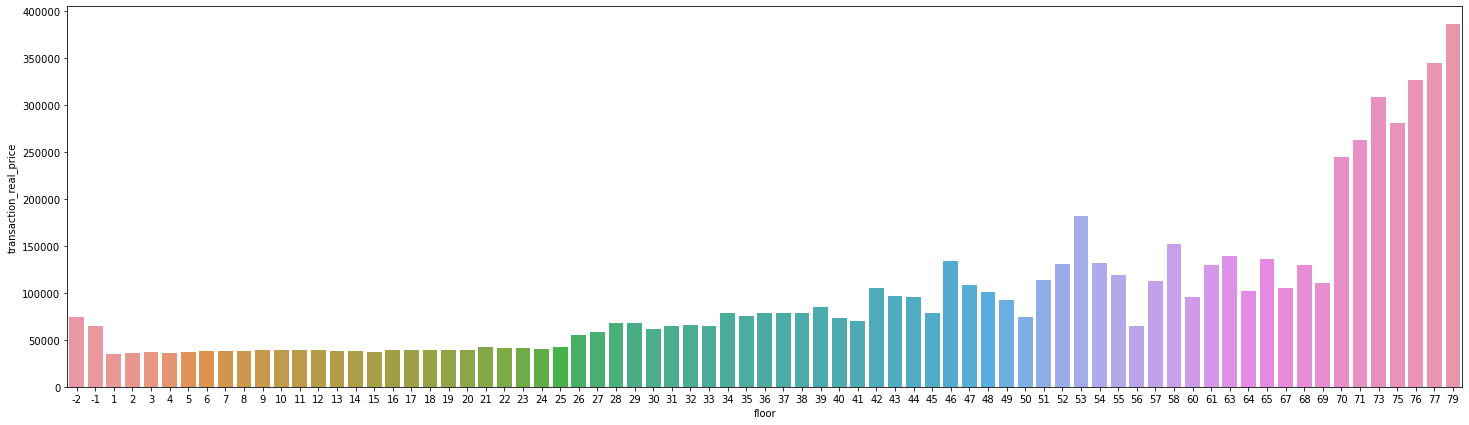

In [ ]:
## 층 별 가격 시각화
f, ax = plt.subplots(figsize=(25, 7))
group = train.groupby(['floor']).mean()['transaction_real_price']
sns.barplot(group.index, group)

층별 가격을 살펴보겠습니다.  
일정 층에서는 가격이 다소 평이하나, 고층으로 갈수록 규칙적인 증감이 관찰되네요. 그리고 고층(70F 이상)에서 월등히 증가했습니다!<br>
관측된 data를 바탕으로 floor의 구간별로 label 을 진행하겠습니다.

In [ ]:
whole_X['floor'].describe()

count    128919.000000
mean          9.305005
std           6.564167
min          -2.000000
25%           4.000000
50%           8.000000
75%          13.000000
max          79.000000
Name: floor, dtype: float64

In [ ]:
## 기존에 floor 를 구간별로 라벨링. -5~25 : 0, 25~49 : 1 … 해서
## floor_group 새 컬럼에 저장
whole_X['floor_group'] = pd.cut(whole_X['floor'], bins=[-5, 25, 49, 61, 75, 80], labels=[0, 1, 2, 3, 4]).astype(int)
whole_X['floor_group'].head()

107102    0
383032    0
468735    0
618109    0
842730    0
Name: floor_group, dtype: int32

In [ ]:
print(whole_X.shape)
whole_X = whole_X.drop('floor', axis=1)
print(whole_X.shape)

(128919, 7)
(128919, 6)


In [ ]:
## 아파트 고유번호의 경우도 오름차순 순으로 → 라벨링
train_apartment_id = train_copy[['apartment_id', 'transaction_real_price']].groupby('apartment_id').mean().sort_values('transaction_real_price').reset_index()
train_apartment_id.head()

,apartment_id,transaction_real_price
0,7165,1428.263889
1,9788,1852.413793
2,7406,1853.189189
3,9789,1855.584416
4,12076,2000.000000


In [ ]:
apartment_id_num = {}
for i in range(len(train_apartment_id)):
    apartment_id = train_apartment_id['apartment_id'][i]
    apartment_id_num[apartment_id] = i


In [ ]:
whole_X

,apartment_id,city,gu,dong,exclusive_use_area,floor_group
107102,9203,1,20,272,59.990,0
383032,11351,1,16,237,59.570,0
468735,7238,1,23,354,112.050,0
618109,5763,1,30,246,62.910,0
842730,2402,0,2,137,131.070,0
...,...,...,...,...,...,...
5458,8965,1,30,376,84.050,0
5459,3831,1,30,467,84.930,0
5460,5550,1,16,202,110.188,0
5461,3371,1,19,252,92.440,0


In [ ]:
whole_X = whole_X.replace({'apartment_id': apartment_id_num})
whole_X.head()

,apartment_id,city,gu,dong,exclusive_use_area,floor_group
107102,9312,1,20,272,59.99,0
383032,8812,1,16,237,59.57,0
468735,9685,1,23,354,112.05,0
618109,9015,1,30,246,62.91,0
842730,7134,0,2,137,131.07,0


In [ ]:
whole_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128919 entries, 107102 to 5462
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   apartment_id        128919 non-null  int64  
 1   city                128919 non-null  int64  
 2   gu                  128919 non-null  int64  
 3   dong                128919 non-null  int64  
 4   exclusive_use_area  128919 non-null  float64
 5   floor_group         128919 non-null  int32  
dtypes: float64(1), int32(1), int64(4)
memory usage: 6.4 MB


In [ ]:
tempdf = pysqldf("select dong, count(dong) from whole_X group by dong")
tempdf

,dong,count(dong)
0,0,2
1,3,20
2,5,4
3,6,16
4,7,12
...,...,...
451,468,2
452,469,32
453,470,4
454,471,344


Index(['apartment_id', 'city', 'gu', 'dong', 'exclusive_use_area',
       'floor_group'],
      dtype='object')


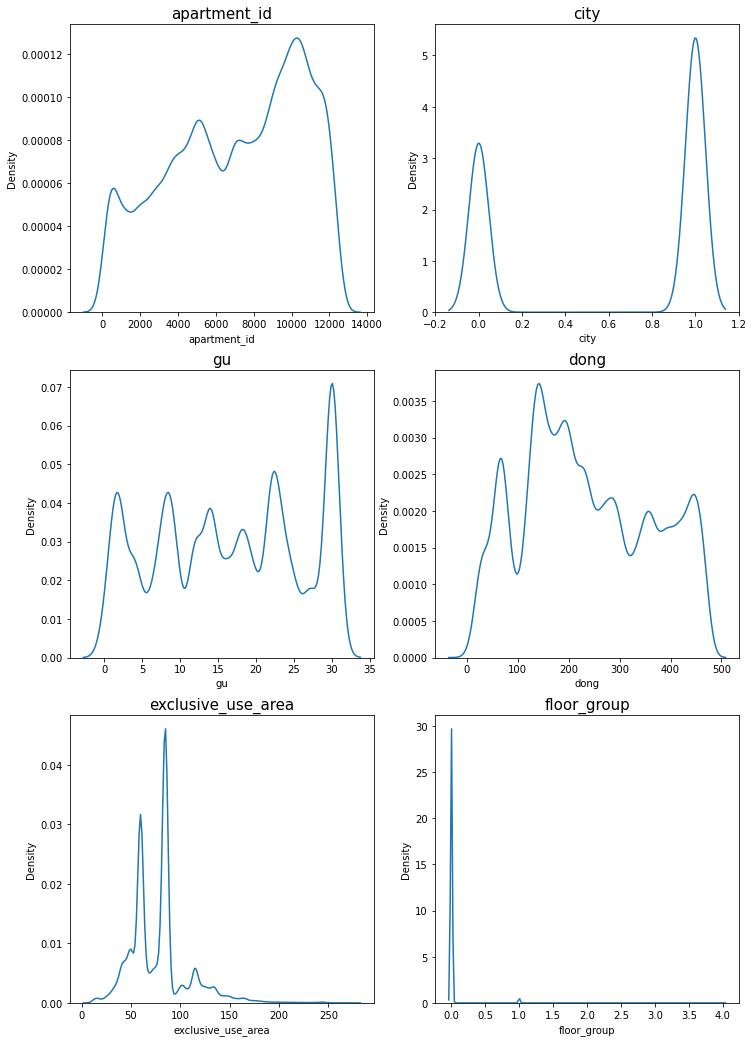

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(12, 18))

columns = whole_X.columns

print(columns)

count = 0
for row in range(3):
    for col in range(2):
        sns.kdeplot(data=whole_X[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == whole_X.shape[1]:
            break

plt.show()

In [ ]:
train_y.values

array([ 33500,  28300,  58500, ..., 319500,  15000, 104000], dtype=int64)

In [ ]:
train_temp = whole_X.iloc[:len(train), :]

train_temp.loc[:, 'transaction_real_price'] = train_y.values
train_temp.head()

,apartment_id,city,gu,dong,exclusive_use_area,floor_group,transaction_real_price
107102,9312,1,20,272,59.99,0,33500
383032,8812,1,16,237,59.57,0,28300
468735,9685,1,23,354,112.05,0,58500
618109,9015,1,30,246,62.91,0,30000
842730,7134,0,2,137,131.07,0,40500


모든 column들이 비교 가능한 '수'적 자료로 준비되었으니, 히트맵을 통해 상관관계를 살펴볼게요.

<AxesSubplot:>

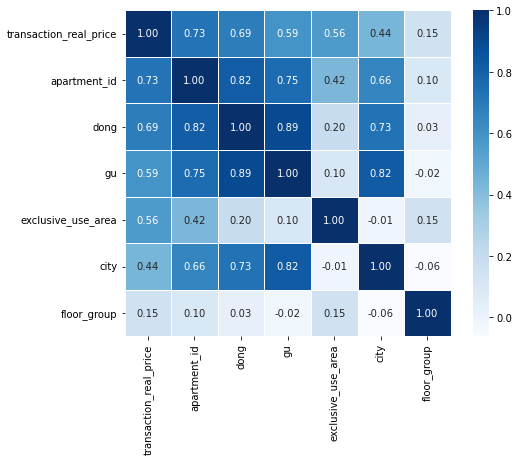

In [ ]:
#상관관계 확인
k = train_temp.shape[1] #히트맵 변수 갯수
corr_mat = train_temp.corr() #변수간의 상관관계
cols = corr_mat.nlargest(k, 'transaction_real_price')['transaction_real_price'].index #price기준으로 제일 큰순서대로 20개를 뽑아냄
cm = np.corrcoef(train_temp[cols].values.T)

f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(data = cm, annot=True, square=True, fmt = '.2f', linewidths=.5, cmap='Blues', 
            yticklabels = cols.values, xticklabels = cols.values)

처음에 관찰했던 전용면적(exclusive_use_area)뿐만 아니라 apartment_id / dong / gu 순서로 높은 연관관계를 보이네요.  
city data가 집값이 높은 서울/부산이기에 도시에 대한 상관관계는 비교적 낮아보입니다.

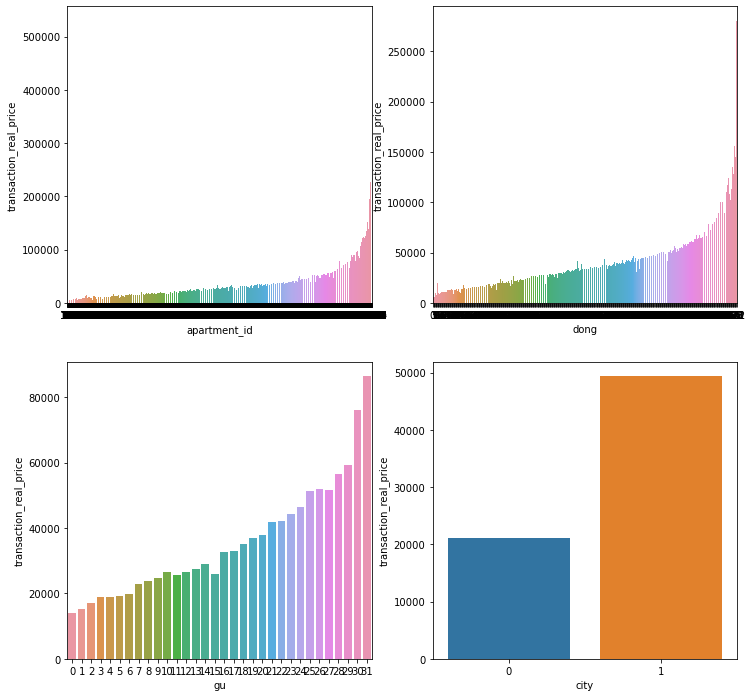

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

cols = ['apartment_id', 'dong', 'gu', 'city']
count = 0
for col in cols:
    sns.barplot(x=whole_X.iloc[:len(train_X)][col], y=train_y, ax=ax[count // 2][count % 2], ci=None)
    count += 1
    if count == len(cols):
        break
            
plt.show()

---

위에서 관찰한 그래프 중 한쪽으로 값이 치우쳐진 값들에 대해 로그변환을 취해 적절히 분포된 값이 되도록 하려합니다.

<AxesSubplot:xlabel='exclusive_use_area', ylabel='Count'>

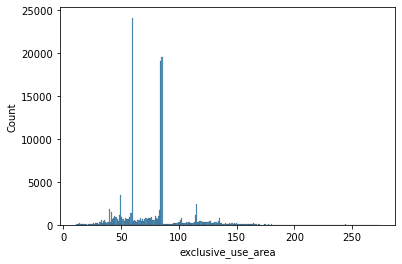

In [ ]:
## 전용면적의 히스토그램
sns.histplot(whole_X['exclusive_use_area'])

In [ ]:
## 전용면적 정규분포에 가깝게 로그씌운다
skew_columns = ['apartment_id', 'exclusive_use_area']

for column in skew_columns:
    whole_X[column] = np.log1p(whole_X[column].values)

<AxesSubplot:xlabel='exclusive_use_area', ylabel='Count'>

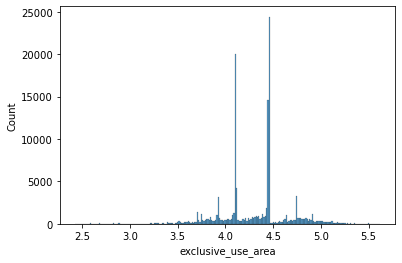

In [ ]:
## 전용면적의 히스토그램
sns.histplot(whole_X['exclusive_use_area'])

<AxesSubplot:xlabel='apartment_id', ylabel='Count'>

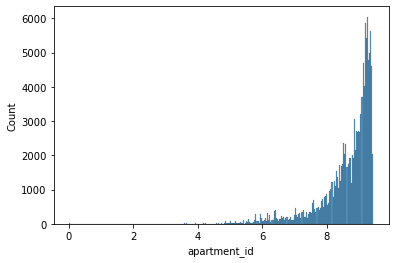

In [ ]:
## 아파트ID 히스토그램 (거래량)
sns.histplot(whole_X['apartment_id'])

In [ ]:
## 컬럼들의 이름 확인
whole_X.columns

Index(['apartment_id', 'city', 'gu', 'dong', 'exclusive_use_area',
       'floor_group'],
      dtype='object')

In [ ]:
## OHE
# whole_X = pd.get_dummies(whole_X, columns=['apartment_id', 'city', 'gu', 'dong', 'floor_group'])
whole_X = pd.get_dummies(whole_X, columns=['city', 'gu', 'dong', 'floor_group'])

In [ ]:
whole_X.head()

,apartment_id,exclusive_use_area,city_0,city_1,gu_0,gu_1,gu_2,gu_3,gu_4,gu_5,...,dong_468,dong_469,dong_470,dong_471,dong_472,floor_group_0,floor_group_1,floor_group_2,floor_group_3,floor_group_4
107102,9.139167,4.110710,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
383032,9.083983,4.103800,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
468735,9.178437,4.727830,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
618109,9.106756,4.157476,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
842730,8.872768,4.883332,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
train_y.describe()

count    123456.000000
mean      38444.401349
std       31357.799111
min         660.000000
25%       19000.000000
50%       31000.000000
75%       47000.000000
max      760000.000000
Name: transaction_real_price, dtype: float64

train_y -> Skewness: 3.510647, Kurtosis: 27.117764


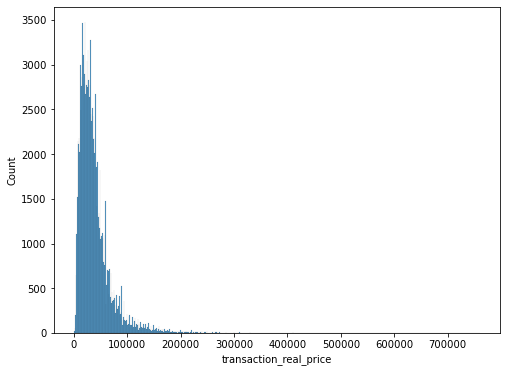

In [ ]:
## 왜도／첨도 확인
f, ax = plt.subplots(figsize = (8,6))
sns.histplot(train_y)
print("%s -> Skewness: %f, Kurtosis: %f" %  ('train_y', train_y.skew(), train_y.kurt()))

In [ ]:
## 로그씌워서 왜도／첨도 확인
train_y = np.log1p(train_y)
print("%s -> Skewness: %f, Kurtosis: %f" %  ('train_y', train_y.skew(), train_y.kurt()))

train_y -> Skewness: -0.091145, Kurtosis: 0.254423


- 왜도(Skewness) : 왼쪽으로 치우쳐져 있을수록 값이크고, 오른쪽으로 치우쳐져 있을 수록 값이 작아진다. 즉, 0에 가까울수록 좋은 형태
- 첨도(Kurtosis) : 첨도 값이 3에 가까울 경우 정규분포에 가까우며, 첨도 값이 클수록 뾰족하고 값이 작을 수록 완만해진다

<AxesSubplot:xlabel='transaction_real_price', ylabel='Count'>

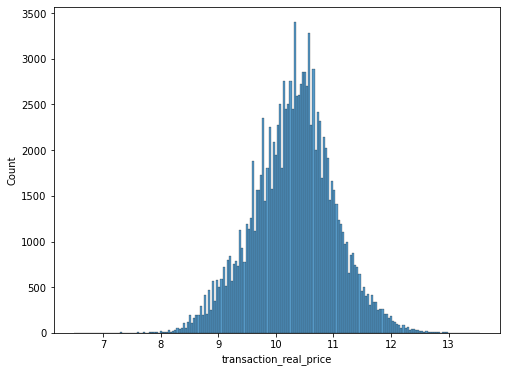

In [ ]:
## 결과 시각화
f, ax = plt.subplots(figsize = (8,6))
sns.histplot(train_y)

로그변환 결과, 왜도와 첨도의 값이 정규분포에 가까워짐에 따라 그래프도 그러한 양상을 띄게되었습니다!

In [ ]:
## train_X, test_X 에 저장
train_X = whole_X.iloc[:len(train), :]
test_X = whole_X.iloc[len(train):, :]

print(train_X.shape)
print(test_X.shape)

(123456, 497)
(5463, 497)


In [ ]:
train_X.head()

,apartment_id,exclusive_use_area,city_0,city_1,gu_0,gu_1,gu_2,gu_3,gu_4,gu_5,...,dong_468,dong_469,dong_470,dong_471,dong_472,floor_group_0,floor_group_1,floor_group_2,floor_group_3,floor_group_4
107102,9.139167,4.110710,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
383032,9.083983,4.103800,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
468735,9.178437,4.727830,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
618109,9.106756,4.157476,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
842730,8.872768,4.883332,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


---

# 4. Functions

### 4.1 random_state

다양한 전처리 방법과 모델을 사용하며 반복하는 과정이었습니다.  
난수의 일관성을 유지함으로써 각각의 모델을 공정히 비교하기 위해 random_state를 고정했습니다.

In [ ]:
random_state = 9

<hr>

### 4.2 Functions

이후 modeling에서 사용 할 함수들을 미리 정의해두었습니다.

  4.2.1. 적절한 Grid 값을 얻기위한 GridSearch 함수

In [ ]:
def my_GridSearch(model, train_X, train_y, param_grid, verbose=2, n_jobs=7):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train_X, train_y)

    # 퍙기 결과 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 평가 결과를 담을 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-results['score'])
    results = results.sort_values('RMSLE')

    return results

4.2.2. 최적의 test size값을 얻기 위한 함수

In [ ]:
def tsize(train_X): # 지극히 주관적인 적당한 test size 값 찾는 함수
    length = len(train_X)
    return round(0.14 * (1 + length / 10 ** 4) ** (10 ** 4 / length) - 0.13, 2)

4.2.3. RMSE 손실 함수

In [ ]:
def rmse(y_test, y_pred): # RMSE 손실 함수
    # 로그를 씌웠던 레이블에 다시 지수를 씌워서 스케일을 원상복구하고 평가하기
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

4.2.4. 모델별 RMSE 결과 값을 비교하기 위한 함수

In [ ]:
def get_scores(models, train_X, train_y):
    scores = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, random_state=random_state, test_size=tsize(train_X))
        
        scaler = RobustScaler() # 표준화 스케일러
        X_train = scaler.fit_transform(X_train) # X_train 데이터를 fit과 동시에 transform
        X_test = scaler.transform(X_test) # X_test 데이터를 transform
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        scores[model_name] = rmse(y_test, y_pred) # 모델 별 RMSE 값 계산
        scores_df = pd.DataFrame(scores, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return scores_df

4.2.5. csv산출물로써 결과파일(submission)을 출력하기 위한 함수

In [ ]:
def save_submission(last_model, train_X, train_y, test_X):

    model_name = last_model.__class__.__name__

    last_model.fit(train_X, train_y)

    test_y = last_model.predict(test_X)

    test_y = np.expm1(test_y) # 스케일 원상복구

    ## 전역 data_dir 가져옴
    # data_dir = data_dir
    data_dir = os.getenv('USERPROFILE')+'/Datathon/data'
    # data_dir = '/content/drive/MyDrive/AIFFEL/Workspace/Project/Datathon/data'
    
    submission_path = join(data_dir, 'submission.csv')
    submission = pd.read_csv(submission_path)
    submission['transaction_real_price'] = test_y

    submission_csv_path = '{}\submission_{}.csv'.format(data_dir, model_name)
    # submission_csv_path = '{}/submission_{}.csv'.format(data_dir, model_name)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

---

# 5. Modeling

### 5.1. LGBMRegressor

In [ ]:
model = LGBMRegressor(random_state=random_state)

param_grid = {
    'n_estimators': [5000, 6000],
    'max_depth': [15, 25]
}

my_GridSearch(model, train_X, train_y, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [ ]:
train_X.info()


In [ ]:
train_y.describe()

In [ ]:
print(train_X.shape, train_y.shape, test_X.shape)

In [ ]:
last_model = LGBMRegressor(max_depth=2, n_estimators=1000)

In [ ]:
save_submission(last_model, train_X, train_y, test_X)

---

### 5.2. VotingRegressor(XGBoost/LightGBM)

In [ ]:
# 탐색할 parameter 준비
param_grid = {
    'boosting' : ['goss', 'gbdt'],
    'n_estimators': [1400, 1600],
    'max_depth': [5, 9],
    'learning_rate': [0.015, 0.019]
    #'num_leaves' : [127, 255, 511]
}

In [ ]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train_X, train_y, param_grid, verbose=2, n_jobs=-1)

In [ ]:
param_grid = {
    'n_estimators': [500, 900],
    'max_depth': [5, 9],
    'learning_rate': [0.05, 0.5]
    #'num_leaves' : [127, 255, 511]
}
model = XGBRegressor(random_state=random_state)
my_GridSearch(model, train_X, train_y, param_grid, verbose=2, n_jobs=-1)

In [ ]:
xgboost = XGBRegressor(learning_rate=0.05, max_depth=5, n_estimators=900, random_state=random_state)
lightgbm0 = LGBMRegressor(boosting='goss', learning_rate=0.015, max_depth=5, n_estimators=1600, random_state=random_state)
lightgbm1 = LGBMRegressor(boosting='gbdt', learning_rate=0.019, max_depth=5, n_estimators=1600, random_state=random_state)
lightgbm2 = LGBMRegressor(boosting='goss', learning_rate=0.019, max_depth=5, n_estimators=1900, random_state=random_state)
lightgbm3 = LGBMRegressor(boosting='gbdt', learning_rate=0.019, max_depth=9, n_estimators=1600, random_state=random_state)
ereg = VotingRegressor(estimators=[('xgb', xgboost), ('lgbm0', lightgbm0), ('lgbm1', lightgbm1), ('lgbm2', lightgbm2), ('lgbm3', lightgbm3)])

In [ ]:
# save_submission 함수 선언
def save_model(y_pred, model_name, rmsle=None):
    data_dir = './data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    
    submission['transaction_real_price'] = np.expm1(y_pred)
    
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [ ]:
save_submission(ereg, train_X, train_y, test_X, "VOTE", "[RMSLE VALUE]")

---

# 6. 1st Results

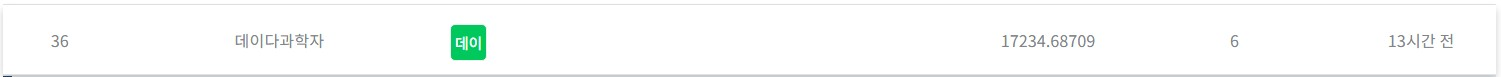

---

---

# 7. 전처리와 모델링을 개선하여 거듭 수행했습니다.

# 7.1. Data check

In [ ]:
import os
from os.path import join

from tqdm import tqdm #진행률바
import re
import optuna
from optuna.integration import XGBoostPruningCallback

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import bisect

from sklearn.preprocessing import  LabelEncoder #문자를 숫자로 인코딩
from sklearn.model_selection import TimeSeriesSplit #변수n을 입력, n번의 반복으로 교차검즘을 할 것인지 정하는 것

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge #선형 모델
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

In [ ]:
print(pd.__version__)

1.4.3


In [ ]:
# 코랩
# from google.colab import drive
# drive.mount('/content/drive')
# data_dir = '/content/drive/MyDrive/AIFFEL/Workspace/Project/Datathon/data'

# 로컬
data_dir = os.getenv('USERPROFILE') + '\OneDrive - 수원대학교\Office\AIFFEL\Workspace\Project\Datathon\data'

In [ ]:
train_path = join(data_dir, 'train.csv')
test_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_path, index_col=0).reset_index(drop=True)
test_X = pd.read_csv(test_path, index_col=0).reset_index(drop=True)

print(train.shape, test_X.shape)

(1216553, 13) (5463, 12)


In [ ]:
train_copy = train.copy()

## 표본 추출을 통해 train 데이터의 수를 줄이겠습니다.
train = train.sample(frac=0.05, random_state=9)
train.shape

(60828, 13)

In [ ]:
train.head()

,apartment_id,city,gu,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
233536,5959,서울특별시,노원구,상계동,720,상계주공6(고층),상계동 720 상계주공6(고층),58.01,1988,201605,11~20,9,30000
309676,4399,서울특별시,강서구,신정동,326,목동신시가지12,신정동 326 목동신시가지12,71.64,1988,200908,21~31,9,59800
799304,1334,부산광역시,북구,구포동,1103-2,구포현대,구포동 1103-2 구포현대,61.20,1994,200803,1~10,3,8200
834293,8752,부산광역시,북구,화명동,1426-1,우신,화명동 1426-1 우신,57.26,1987,201503,11~20,5,16100
656397,6914,부산광역시,서구,암남동,81-12,송도자유비치,암남동 81-12 송도자유비치,59.79,1997,201202,11~20,11,10000


In [ ]:
test_X.head()

,apartment_id,city,gu,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor
0,10453,서울특별시,강서구,목동,938,청학,목동 938 청학,35.5500,2002,201711,11~20,2
1,989,부산광역시,동구,초량동,1143-8,고관맨션,초량동 1143-8 고관맨션,68.7200,1977,201708,21~31,2
2,8597,부산광역시,사하구,괴정동,447-13,우림그린,괴정동 447-13 우림그린,72.5400,1989,201710,11~20,2
3,11086,서울특별시,강남구,대치동,1007-2,풍림아이원4차(1007-2),대치동 1007-2 풍림아이원4차(1007-2),111.5400,2004,201707,1~10,10
4,2121,부산광역시,사하구,다대동,1670,다대롯데캐슬블루,다대동 1670 다대롯데캐슬블루,119.6398,2014,201712,11~20,21


데이터 정보

0. apartment_id: 아파트 아이디
1. city: 도시
2. dong: 동
3. jibun: 지번
4. apt: 아파트단지 이름
5. addr_kr: 주소
6. exclusive_use_area: 전용면적
7. year_of_completion: 설립일자
8. transaction_year_month: 거래년월
9. transaction_date: 거래날짜
10. floor: 층
11. transaction_real_price: 실거래가(train 만 존재)

<AxesSubplot:>

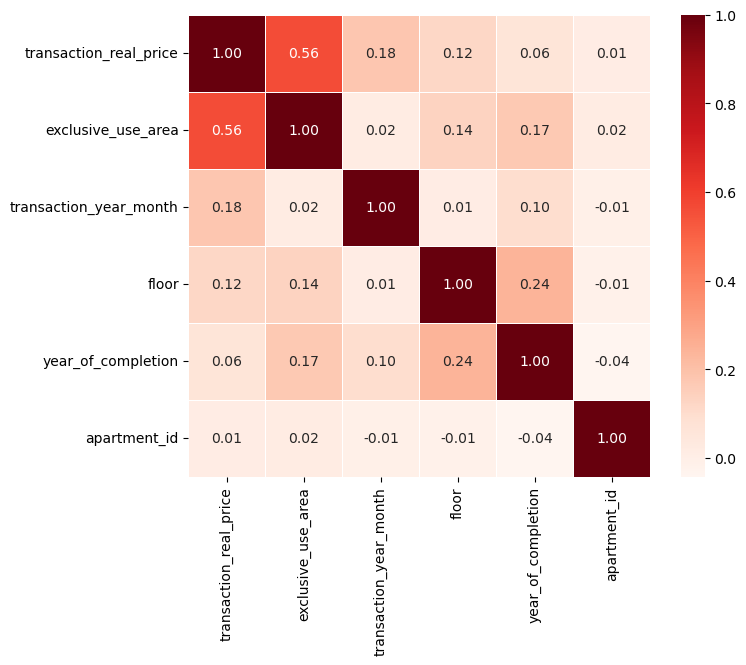

In [ ]:
#상관관계 확인
k = train.shape[1] #히트맵 변수 갯수
corr_mat = train.corr() #변수간의 상관관계
cols = corr_mat.nlargest(k, 'transaction_real_price')['transaction_real_price'].index #price기준으로 제일 큰순서대로 20개를 뽑아냄
cm = np.corrcoef(train[cols].values.T)

f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(data = cm, annot=True, square=True, fmt = '.2f', linewidths=.5, cmap='Reds', 
            yticklabels = cols.values, xticklabels = cols.values)

# 7.2. Merge : Test / Train DATA

In [ ]:
train_y = train['transaction_real_price']
print(train_y.head())

print(train.shape)
train_X = train.drop('transaction_real_price', axis=1)
print(train_X.shape)

233536    30000
309676    59800
799304     8200
834293    16100
656397    10000
Name: transaction_real_price, dtype: int64
(60828, 13)
(60828, 12)


In [ ]:
whole_X = pd.concat((train_X, test_X), axis=0)
whole_X.shape

(66291, 12)

In [ ]:
whole_X.head()

,apartment_id,city,gu,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor
233536,5959,서울특별시,노원구,상계동,720,상계주공6(고층),상계동 720 상계주공6(고층),58.01,1988,201605,11~20,9
309676,4399,서울특별시,강서구,신정동,326,목동신시가지12,신정동 326 목동신시가지12,71.64,1988,200908,21~31,9
799304,1334,부산광역시,북구,구포동,1103-2,구포현대,구포동 1103-2 구포현대,61.20,1994,200803,1~10,3
834293,8752,부산광역시,북구,화명동,1426-1,우신,화명동 1426-1 우신,57.26,1987,201503,11~20,5
656397,6914,부산광역시,서구,암남동,81-12,송도자유비치,암남동 81-12 송도자유비치,59.79,1997,201202,11~20,11


In [ ]:
whole_X.describe()

,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor
count,66291.000000,66291.000000,66291.000000,66291.000000,66291.000000
mean,6313.173251,78.150135,1998.507294,201333.375767,9.237966
std,3580.013258,29.539416,9.049267,300.136513,6.547386
min,2.000000,10.321500,1961.000000,200801.000000,-1.000000
25%,3351.000000,59.760000,1993.000000,201101.000000,4.000000
50%,5967.000000,81.760000,2000.000000,201405.000000,8.000000
75%,9436.000000,84.970000,2005.000000,201606.000000,13.000000
max,12654.000000,273.860000,2017.000000,201712.000000,80.000000


In [ ]:
whole_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66291 entries, 233536 to 5462
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   apartment_id            66291 non-null  int64  
 1   city                    66291 non-null  object 
 2   gu                      66291 non-null  object 
 3   dong                    66291 non-null  object 
 4   jibun                   66291 non-null  object 
 5   apt                     66291 non-null  object 
 6   addr_kr                 66291 non-null  object 
 7   exclusive_use_area      66291 non-null  float64
 8   year_of_completion      66291 non-null  int64  
 9   transaction_year_month  66291 non-null  int64  
 10  transaction_date        66291 non-null  object 
 11  floor                   66291 non-null  int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 6.6+ MB


# 7.3. Exploratory Data Analysis

In [ ]:
print(whole_X.shape)
whole_X = whole_X.drop(['jibun', 'apt', 'addr_kr', 'transaction_date'], axis=1)
print(whole_X.shape)

(66291, 12)
(66291, 8)


In [ ]:
whole_X['year_of_completion'] = pd.to_datetime(whole_X['year_of_completion'].apply(lambda x: str(x)[:4])).dt.year

In [ ]:
whole_X['year_of_completion']

233536    1988
309676    1988
799304    1994
834293    1987
656397    1997
          ... 
5458      2003
5459      2009
5460      2004
5461      2005
5462      1993
Name: year_of_completion, Length: 66291, dtype: int64

In [ ]:
whole_X['transaction_year_month'] = pd.to_datetime(whole_X['transaction_year_month'].apply(lambda x: str(x)[:4])).dt.year

In [ ]:
whole_X['transaction_year_month']

233536    2016
309676    2009
799304    2008
834293    2015
656397    2012
          ... 
5458      2017
5459      2017
5460      2017
5461      2017
5462      2017
Name: transaction_year_month, Length: 66291, dtype: int64

C:\Users\Hugh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='floor', ylabel='transaction_real_price'>

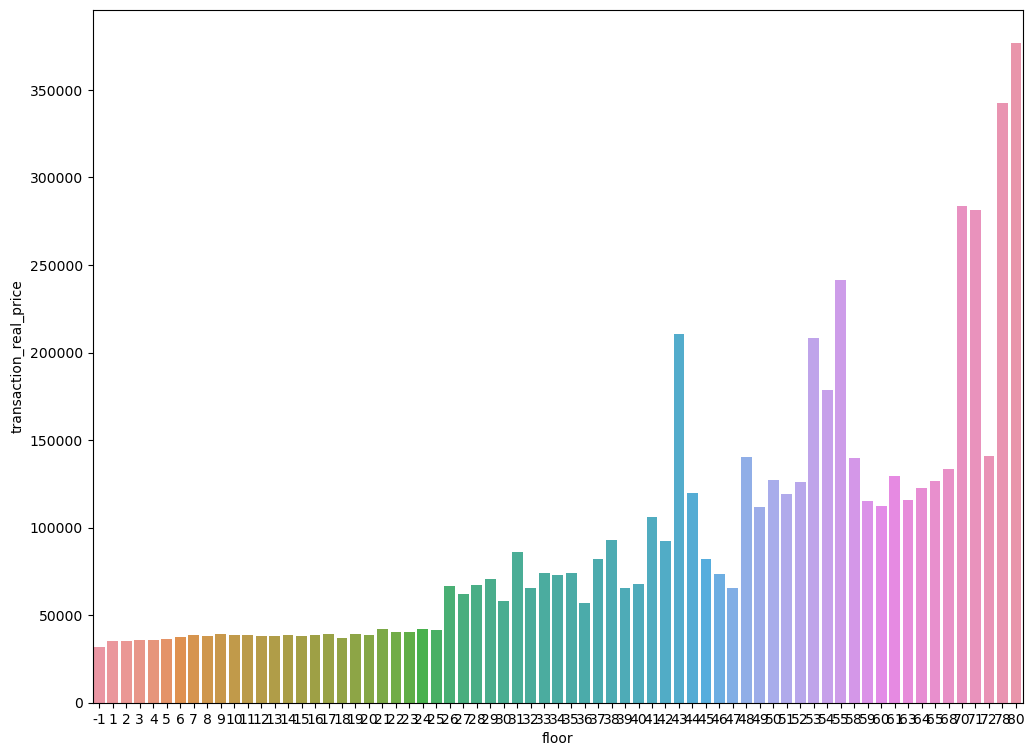

In [ ]:
f, ax = plt.subplots(figsize=(12, 9))
group = train.groupby(['floor']).mean()['transaction_real_price']
sns.barplot(group.index, group)

In [ ]:
whole_X['floor'].describe()

count    66291.000000
mean         9.237966
std          6.547386
min         -1.000000
25%          4.000000
50%          8.000000
75%         13.000000
max         80.000000
Name: floor, dtype: float64

In [ ]:
whole_X['floor'] = whole_X['floor'] + 4
whole_X['floor'].head()

233536    13
309676    13
799304     7
834293     9
656397    15
Name: floor, dtype: int64

In [ ]:
whole_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66291 entries, 233536 to 5462
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   apartment_id            66291 non-null  int64  
 1   city                    66291 non-null  object 
 2   gu                      66291 non-null  object 
 3   dong                    66291 non-null  object 
 4   exclusive_use_area      66291 non-null  float64
 5   year_of_completion      66291 non-null  int64  
 6   transaction_year_month  66291 non-null  int64  
 7   floor                   66291 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 4.6+ MB


In [ ]:
# fig, ax = plt.subplots(4, 2, figsize=(12, 18))

# columns = whole_X.columns
# count = 0
# for row in range(4):
#     for col in range(2):
#         sns.kdeplot(data=whole_X[columns[count]], ax=ax[row][col])
#         ax[row][col].set_title(columns[count], fontsize=15)
#         count += 1
#         if count == whole_X.shape[1]:
#             break
            
# plt.show()

In [ ]:
train_y.values

array([30000, 59800,  8200, ..., 19500, 41900, 47500], dtype=int64)

In [ ]:
train_temp = whole_X.iloc[:len(train), :]

train_temp.loc[:, 'transaction_real_price'] = train_y.values
train_temp.head()

C:\Users\Hugh\AppData\Local\Temp\ipykernel_7960\458979734.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_temp.loc[:, 'transaction_real_price'] = train_y.values


,apartment_id,city,gu,dong,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price
233536,5959,서울특별시,노원구,상계동,58.01,1988,2016,13,30000
309676,4399,서울특별시,강서구,신정동,71.64,1988,2009,13,59800
799304,1334,부산광역시,북구,구포동,61.20,1994,2008,7,8200
834293,8752,부산광역시,북구,화명동,57.26,1987,2015,9,16100
656397,6914,부산광역시,서구,암남동,59.79,1997,2012,15,10000


<AxesSubplot:>

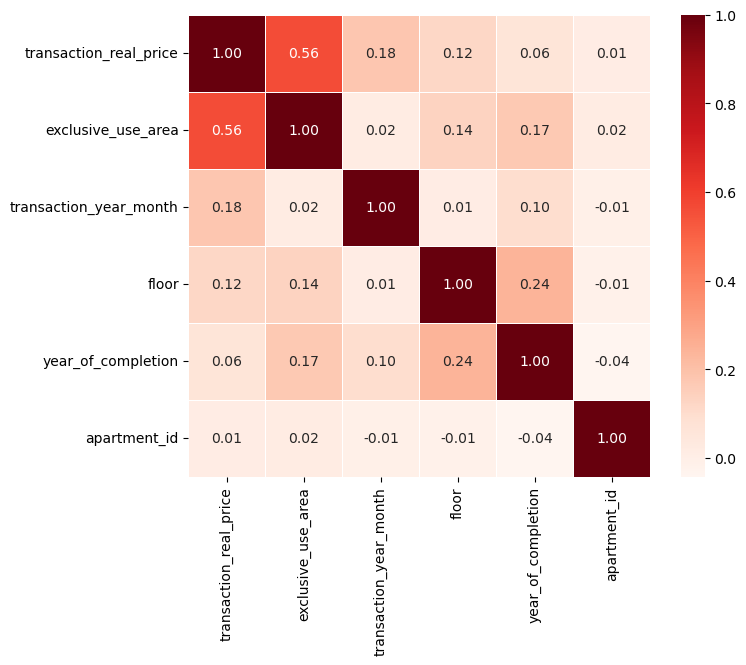

In [ ]:
#상관관계 확인
k = train_temp.shape[1] #히트맵 변수 갯수
corr_mat = train_temp.corr() #변수간의 상관관계
cols = corr_mat.nlargest(k, 'transaction_real_price')['transaction_real_price'].index #price기준으로 제일 큰순서대로 20개를 뽑아냄
cm = np.corrcoef(train_temp[cols].values.T)

f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(data = cm, annot=True, square=True, fmt = '.2f', linewidths=.5, cmap='Reds', 
            yticklabels = cols.values, xticklabels = cols.values)

In [ ]:
skew_columns = ['exclusive_use_area', 'floor']

for column in skew_columns:
    whole_X[column] = np.log1p(whole_X[column].values)

<AxesSubplot:xlabel='apartment_id', ylabel='Count'>

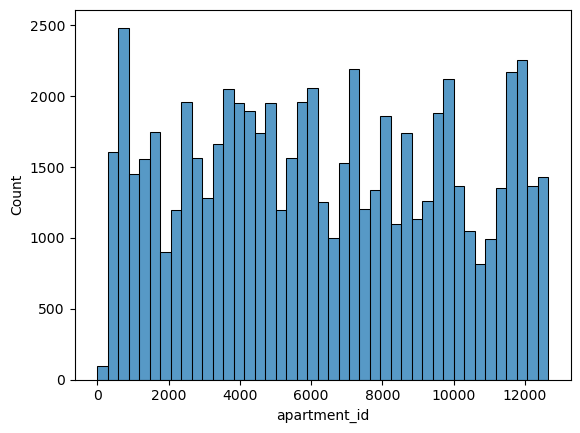

In [ ]:
sns.histplot(whole_X['apartment_id'])

<AxesSubplot:xlabel='exclusive_use_area', ylabel='Count'>

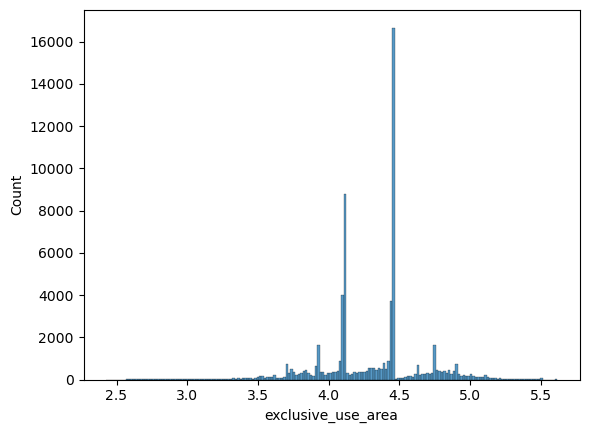

In [ ]:
sns.histplot(whole_X['exclusive_use_area'])

<AxesSubplot:xlabel='floor', ylabel='Count'>

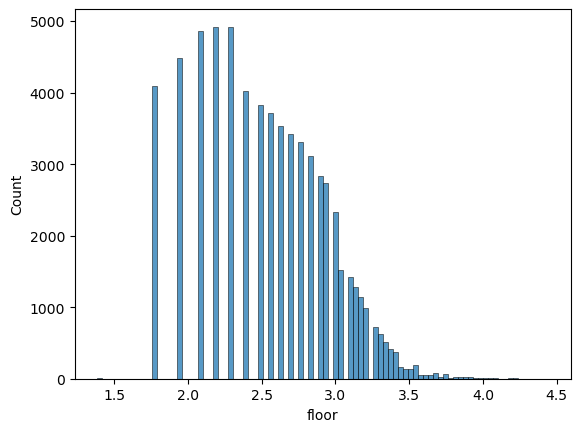

In [ ]:
sns.histplot(whole_X['floor'])

In [ ]:
whole_X.columns

Index(['apartment_id', 'city', 'gu', 'dong', 'exclusive_use_area',
       'year_of_completion', 'transaction_year_month', 'floor'],
      dtype='object')

In [ ]:
whole_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66291 entries, 233536 to 5462
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   apartment_id            66291 non-null  int64  
 1   city                    66291 non-null  object 
 2   gu                      66291 non-null  object 
 3   dong                    66291 non-null  object 
 4   exclusive_use_area      66291 non-null  float64
 5   year_of_completion      66291 non-null  int64  
 6   transaction_year_month  66291 non-null  int64  
 7   floor                   66291 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 4.6+ MB


In [ ]:
whole_X

,apartment_id,city,gu,dong,exclusive_use_area,year_of_completion,transaction_year_month,floor
233536,5959,서울특별시,노원구,상계동,4.077707,1988,2016,2.639057
309676,4399,서울특별시,강서구,신정동,4.285516,1988,2009,2.639057
799304,1334,부산광역시,북구,구포동,4.130355,1994,2008,2.079442
834293,8752,부산광역시,북구,화명동,4.064916,1987,2015,2.302585
656397,6914,부산광역시,서구,암남동,4.107425,1997,2012,2.772589
...,...,...,...,...,...,...,...,...
5458,8965,서울특별시,강남구,양재동,4.443239,2003,2017,2.484907
5459,3831,서울특별시,강남구,반포동,4.453533,2009,2017,2.197225
5460,5550,서울특별시,구로구,구로동,4.711222,2004,2017,3.332205
5461,3371,서울특별시,서대문구,홍제동,4.537320,2005,2017,1.791759


In [ ]:
whole_X_onehot = pd.get_dummies(whole_X, columns=['apartment_id', 'city', 'gu', 'dong', 'year_of_completion', 'transaction_year_month'])

In [ ]:
whole_X_onehot

,exclusive_use_area,floor,apartment_id_2,apartment_id_5,apartment_id_12,apartment_id_14,apartment_id_17,apartment_id_18,apartment_id_19,apartment_id_20,...,transaction_year_month_2008,transaction_year_month_2009,transaction_year_month_2010,transaction_year_month_2011,transaction_year_month_2012,transaction_year_month_2013,transaction_year_month_2014,transaction_year_month_2015,transaction_year_month_2016,transaction_year_month_2017
233536,4.077707,2.639057,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
309676,4.285516,2.639057,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
799304,4.130355,2.079442,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
834293,4.064916,2.302585,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
656397,4.107425,2.772589,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5458,4.443239,2.484907,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5459,4.453533,2.197225,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5460,4.711222,3.332205,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5461,4.537320,1.791759,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
train_y.describe()

count     60828.000000
mean      38250.835027
std       31332.999667
min        1000.000000
25%       19000.000000
50%       31000.000000
75%       47000.000000
max      650000.000000
Name: transaction_real_price, dtype: float64

train_y -> Skewness: 3.526791, Kurtosis: 24.890904


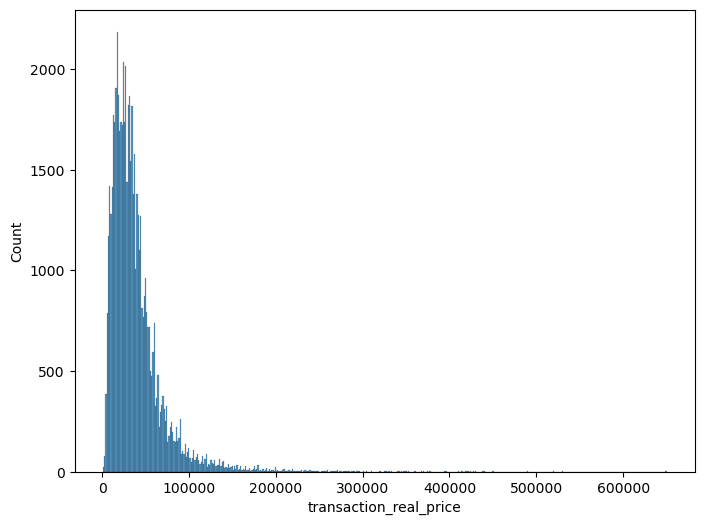

In [ ]:
f, ax = plt.subplots(figsize = (8,6))
sns.histplot(train_y)
print("%s -> Skewness: %f, Kurtosis: %f" %  ('train_y', train_y.skew(), train_y.kurt()))

In [ ]:
train_y = np.log1p(train_y)
print("%s -> Skewness: %f, Kurtosis: %f" %  ('train_y', train_y.skew(), train_y.kurt()))

train_y -> Skewness: -0.087722, Kurtosis: 0.246559


<AxesSubplot:xlabel='transaction_real_price', ylabel='Count'>

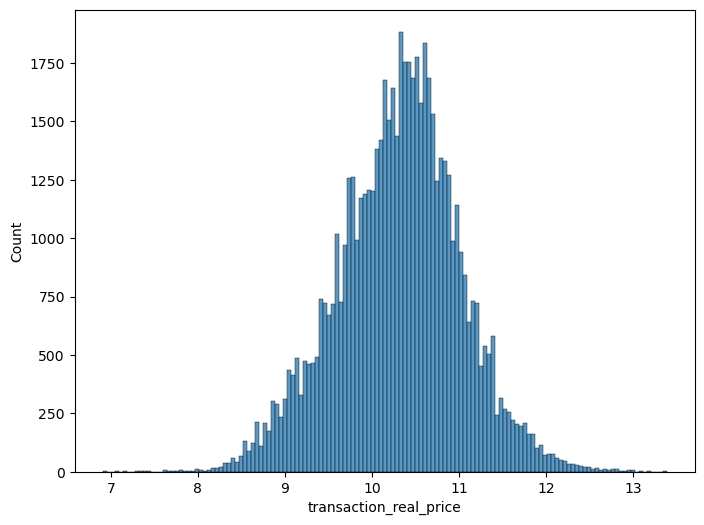

In [ ]:
f, ax = plt.subplots(figsize = (8,6))
sns.histplot(train_y)

In [ ]:
train_X = whole_X_onehot.iloc[:len(train), :]
test_X = whole_X_onehot.iloc[len(train):, :]

print(train_X.shape)
print(test_X.shape)

(60828, 9348)
(5463, 9348)


In [ ]:
train_X.head()

,exclusive_use_area,floor,apartment_id_2,apartment_id_5,apartment_id_12,apartment_id_14,apartment_id_17,apartment_id_18,apartment_id_19,apartment_id_20,...,transaction_year_month_2008,transaction_year_month_2009,transaction_year_month_2010,transaction_year_month_2011,transaction_year_month_2012,transaction_year_month_2013,transaction_year_month_2014,transaction_year_month_2015,transaction_year_month_2016,transaction_year_month_2017
233536,4.077707,2.639057,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
309676,4.285516,2.639057,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
799304,4.130355,2.079442,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
834293,4.064916,2.302585,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
656397,4.107425,2.772589,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
def my_GridSearch(model, train_X, train_y, param_grid, verbose=2, n_jobs=7):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train_X, train_y)

    # 퍙기 결과 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 평가 결과를 담을 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-results['score'])
    results = results.sort_values('RMSLE')

    return results

In [ ]:
random_state = 9

In [ ]:
# model = LGBMRegressor(random_state=random_state)

# param_grid = {
#     'n_estimators': [2400, 2500], # 2500
#     'max_depth': [20, 19], # 19
#     # 'num_leaves': [34, 35], # 35
#     # 'min_child_samples': [16, 18], # 18
# }
# my_GridSearch(model, train_X, train_y, param_grid, verbose=2, n_jobs=7)

In [ ]:
def tsize(train_X): # 지극히 주관적인 적당한 test size 값 찾는 함수
    length = len(train_X)
    return round(0.14 * (1 + length / 10 ** 4) ** (10 ** 4 / length) - 0.13, 2)

In [ ]:
def rmse(y_test, y_pred): # RMSE 손실 함수
    # 로그를 씌웠던 레이블에 다시 지수를 씌워서 스케일을 원상복구하고 평가하기
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [ ]:
def get_scores(models, train_X, train_y):
    scores = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, random_state=random_state, test_size=tsize(train_X))
        
        scaler = RobustScaler() # 표준화 스케일러
        X_train = scaler.fit_transform(X_train) # X_train 데이터를 fit과 동시에 transform
        X_test = scaler.transform(X_test) # X_test 데이터를 transform
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        scores[model_name] = rmse(y_test, y_pred) # 모델 별 RMSE 값 계산
        scores_df = pd.DataFrame(scores, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return scores_df

In [ ]:
def save_submission(last_model, train_X, train_y, test_X, n):
    last_model.fit(train_X, train_y)
    test_y = last_model.predict(test_X)
    test_y = np.expm1(test_y) # 스케일 원상복구
    data_dir = os.getenv('USERPROFILE')+'\OneDrive - 수원대학교\Office\AIFFEL\Workspace\Project\Datathon\data'
    # data_dir = '/content/drive/MyDrive/AIFFEL/Workspace/Project/Datathon/data'
    submission_path = join(data_dir, 'submission.csv')
    submission = pd.read_csv(submission_path)
    submission['transaction_real_price'] = test_y

    submission_csv_path = '{}\submission_{}.csv'.format(data_dir, n)
    # submission_csv_path = '{}/submission_{}.csv'.format(data_dir, n)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [ ]:
last_model = LGBMRegressor(max_depth=20, n_estimators=2500, min_child_samples=16, num_leaves=35)

In [ ]:
save_submission(last_model, train_X, train_y, test_X, 1)

C:\Users\Hugh\OneDrive - 수원대학교\Office\AIFFEL\Workspace\Project\Datathon\data\submission_1.csv saved!


---

# 7.4. Final Result

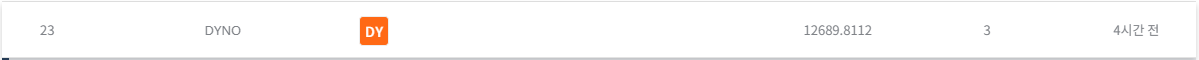

---

# 8. Discussion


#### 아이펠 과정을 시작하고 python과 machine learning에 대한 4주간의 교육 후 진행된 최초의 프로젝트였습니다.  
무엇보다도 프로젝트가 DACON에서 진행된 실전 Dataset으로 이루어져서 더욱 진지하게 다가온 뜻깊은 프로젝트였습니다. 처음 진행하는 프로젝트다보니 많은 어려움과 미숙함들이 있었지만, 그런 크고 작은 경험들을 통해 AI개발자를 향해서 한걸음 더 내딛을 수 있었습니다.

#### 예제코드 없이 csv 데이터만 가지고 초석부터 온전히 코드를 작성하는 것은 결코 쉬운 일이 아니었습니다.  
지금까지의 노드 과제와는 달리, LMS와 git을 뒤져가며 학습했던 내용을 복습하며 아무것도 없는 백지장 위에 코드블럭을 하나하나 쌓아가며, function부터 시작해서 modeling과 parameter를 설정한 경험들은 큰 보람을 가져다 주었고, python 언어에 대한 되새김의 기회였습니다.

#### 단순한 학생이 아닌 데이터 분석가로써 프로젝트에 임했습니다.  
Dataset을 그저 단순히 해결해야 할 과제더미가 아닌, 진지한 분석대상으로써 보고, 그 배경을 살펴보며 정확한 목적을 설정하는 등의 pre-view과정은 대상 데이터에 대한 높은 이해도를 가져다 주었고, 이를 기반으로 좀더 심도 있고 진지하게 진행 할 수 있었기에 매우 유익한 경험이었습니다.

#### 프로젝트를 진행하며 몇가지 아쉬운 부분도 있었지만 그만큼 더 배울 수 있었습니다.  
규모가 큰 데이터셋의 처리가 처음이라서 겪었던 리소스 부족 이슈는, 다양한 컴퓨팅 환경을 탐색하고 학습해보는 기회를 주었습니다. 그리고 팀단위 프로젝트에 대한 경험 부족으로 인한 소통, 작업분배 등의 계획에 대한 어려움은 오히려 협업을 통해 함께 문제를 공유하고 풀어가는 즐거운 경험을 가져다 주었습니다. 이번 프로젝트를 통해 어려운 문제를 함께 해결하고 고충을 나누는 팀 동료에 대한 소중함을 느낄 수 있었습니다.